<a href="https://colab.research.google.com/github/kazahayan/uber-h3-tutorial/blob/main/h3_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leveraging Uber's H3 for Geospatial Analytics

**Niki Kazahaya** | [LinkedIn](https://www.linkedin.com/in/nikikazahaya/)

Hexagonal-based visualizations has become a growing paradigm in geospatial data. Originally developed by Uber, H3 is a grid that divides the earth in contiguous hexagons of different sizes. While its benefits are numerous, a few of the key ones that make it particularly compelling:

* The earth's spherical surface can be tiled with hexagons while limiting dead space between the polygons.
* While administrative boundaries (states, counties, townships, etc) can be powerful units of aggregation, many geospatial trends might not necessarily adhere to these borders.
* Using equally-sized hexagons can provide another perspective on where certain trends are concentrated independent of traditional boundaries.

I originally created [the following visualization](https://www.linkedin.com/posts/jamiesonpotter_agtech-geospatialanalysis-farmdata-activity-7252716909647818752-M6Sf?utm_source=share&utm_medium=member_desktop&rcm=ACoAABlbZyQBHfXuDBts0InnGSw9aaxKd9coZ50) while at CamoAg, a people and land intelligence platform focusing specifically on agriculture. Given the spatial nature of ag, it was a natural marriage with H3. However, I was surprised at the general lack of familiarity of H3 within the ag industry.

I created this short Python tutorial as a brief intro to H3. For more details on H3, I'd also encourage you to check out [the official H3 docs](https://h3geo.org/).

## Setup

The original data used in the visualization above uses CamoAg's proprietary producer dataset. If you are interested in that dataset, please reach out to the CamoAg team. For this tutorial, I will be using data on automotive crashes from [the Illinois Department of Transportation](https://gis-idot.opendata.arcgis.com/search?layout=grid&q=crashes). At minimum, your dataset should have the following to append the H3 identifier:

* Geocodes (latitude, longitude) OR
* An address that can be properly geocoded OR
* Placekeys, a universal identifier for indexing and joining spatial data

In [1]:
!pip install h3 placekey -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.5 MB/s eta 0:00:00


In [2]:
import h3
import folium
import branca
import random

import pandas as pd
import geopandas as gpd
import placekey as pk

from shapely.geometry import Polygon
from google.colab import drive

In [3]:
# allow access to my google account
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# data dropped into the following directory
read_path = '/content/gdrive/MyDrive/Portfolio/il_crash_2023.csv'
raw_df = pd.read_csv(read_path)

# some light data clean up
# the original schema has lots of columns, truncating to a handful for readability
columns_to_keep = ['CrashID', 'CrashYr', 'CrashMonth', 'CrashDay', 'NumberOfVehicles', 'TotalFatals', 'TSCrashLatitude', 'TSCrashLongitude']
il_crash_df = raw_df[columns_to_keep]

# converting columns to lowercase
il_crash_df.columns = il_crash_df.columns.str.lower()

# dropping rows where lat, long might be null
il_crash_df = il_crash_df.dropna(subset=['tscrashlatitude', 'tscrashlongitude'])

il_crash_df.head()

,crashid,crashyr,crashmonth,crashday,numberofvehicles,totalfatals,tscrashlatitude,tscrashlongitude
0,12540335,23,12,28,2,0,40.538577,-88.976572
1,12533719,23,12,31,1,0,40.413355,-90.829813
2,12537061,23,12,23,3,0,42.011760,-87.720660
3,12540471,23,12,5,1,0,39.996231,-87.608870
4,12579771,23,12,13,2,0,38.513759,-89.993639


## Determine Appropriate H3 Resolution

* Determine how large or small you want your hexagons to be.
* Resolution ranges from 0-15 with 0 being the largest and 15 being the smallest.
* Stats for total area/edge lengths can be found [here](https://h3geo.org/docs/core-library/restable/).
* I've used the `average_hexagon_area` function in the H3 library to calculate these on the fly.
* Our final visualization will use resolution 6.

In [5]:
h3_resolution_range = range(0, 16)

h3_resolution_dict = {
    "resolution": list(h3_resolution_range),
    "avg_hex_area_km2": [h3.average_hexagon_area(res) for res in h3_resolution_range]
}

h3_avg_area_df = pd.DataFrame(h3_resolution_dict)
pd.set_option("display.float_format", "{:,.6f}".format)

print(h3_avg_area_df.to_string(index=False))  # dropping index to avoid redundancy

 resolution  avg_hex_area_km2
          0  4,357,449.416078
          1    609,788.441794
          2     86,801.780399
          3     12,393.434655
          4      1,770.347654
          5        252.903858
          6         36.129062
          7          5.161293
          8          0.737328
          9          0.105333
         10          0.015048
         11          0.002150
         12          0.000307
         13          0.000044
         14          0.000006
         15          0.000001


## Append H3 Identifier

If you do not have your data geocoded yet, you can utilize the geocoder of your choice or use these free alternatives:
* [Placekey](https://docs.placekey.io/documentation/geocoder)
* [Census Geocoder](https://geocoding.geo.census.gov/geocoder/) (US only)

Once geocoded, use the `latlng_to_cell` function to convert the lat/long pairs to the H3 identifier. There are two flavors of the H3 index, the 64-bit integer representation of an H3 index or the hexadecimal representation of the integer. We are trying to get the latter as it is considered the canonical identifier for an H3 cell. However, you can easily convert one to the other using the `int_to_str` or `str_to_int` functions in the H3 library (demonstrated in the cell below).

### Lat/Long to H3 Identifier

In [6]:
# basic example on one row
lat, lng = il_crash_df.loc[0, 'tscrashlatitude'], il_crash_df.loc[0, 'tscrashlongitude']
h3_resolution_random = random.choice(h3_resolution_range)  # randomly pick a h3 resolution

h3_str = h3.latlng_to_cell(lat, lng, h3_resolution_random)  # convert lat/long to h3 identifier (string representation)
h3_bit = h3.str_to_int(h3_str)  # convert string representation to 64-bit representation

print(f"string representation (resolution {h3_resolution_random}): {h3_str}")
print(f"integer representation (resolution {h3_resolution_random}): {h3_bit}")
print(f"h3 cell plotted: https://h3geo.org/#hex={h3_str}") # generates link to view cell on map

string representation (resolution 14): 8e26628d0d82767
integer representation (resolution 14): 640186422528583527
h3 cell plotted: https://h3geo.org/#hex=8e26628d0d82767


### Placekey to H3

If you are already using Placekey as your primary key, use the `placekey_to_h3` function from the Placekey library to get the H3 identifier.

In [9]:
placekey = pk.geo_to_placekey(lat, lng)
placekey_to_h3 = pk.placekey_to_h3(placekey)

print(f"H3 identifier using Placekey: {placekey_to_h3}")

H3 identifier using Placekey: 8a26628d0d87fff


### Aggregating by H3

Append the H3s to the entire dataframe using lat/longs or Placekeys and group by the H3 cell. For this basic example, we will get median vehicles involved in a crash per H3 cell (resolution 6).

In [10]:
# apply to the entire dataframe
resolution = 6

il_crash_df["h3_index"] = il_crash_df.apply(
    lambda row: h3.latlng_to_cell(row["tscrashlatitude"], row["tscrashlongitude"], resolution),
    axis=1
)

In [11]:
# quick look at the df after appending h3
il_crash_df.head(2)

,crashid,crashyr,crashmonth,crashday,numberofvehicles,totalfatals,tscrashlatitude,tscrashlongitude,h3_index
0,12540335,23,12,28,2,0,40.538577,-88.976572,8626628d7ffffff
1,12533719,23,12,31,1,0,40.413355,-90.829813,862671c1fffffff


In [12]:
h3_counts_df = (
    il_crash_df.groupby("h3_index")
    .agg(median_vehicles=("numberofvehicles", "median"))  # Compute median number of vehicles per H3 cell
    .reset_index()
    .sort_values(by="median_vehicles", ascending=False)
)

h3_counts_df.head()

,h3_index,median_vehicles
202,862640a5fffffff,3.000000
3297,862675b97ffffff,3.000000
2837,86267170fffffff,3.000000
1254,862646ba7ffffff,3.000000
412,862641807ffffff,2.500000


## Get H3 Boundaries in a GeoDataFrame

* Use the H3 library to get the cell boundaries.
* Pass the cell boundaries through to Shapely to return the polygon object.
* Convert the pandas dataframe to a geodataframe.
* Plot the cells using your preferred mapping library (Folium in this example).



In H3, the cell_to_boundary function will take the H3 identifier and return lat/long pairs (as tuples) representing each vertice of the hexagon. **However, be mindful of the following - Shapely expects long/lats instead of lat/longs.**

In [13]:
def h3_cell_to_polygon(h3_cell: str) -> Polygon:
  """Convert an H3 cell index to a Shapely polygon with long/lat pairs for each vertice."""
  boundary_coordinates = h3.cell_to_boundary(h3_cell)  # returns (lat, lon) coordinates
  boundary_coordinates_reversed = [coordinate[::-1] for coordinate in boundary_coordinates]  # flips to (lon, lat) coordinates
  return Polygon(boundary_coordinates_reversed)  # returns polygon object

In [14]:
# apply function to append geometry for each h3 index
h3_counts_df['geometry'] = h3_counts_df['h3_index'].apply(h3_cell_to_polygon)

# convert the pandas dataframe to a GeoPandas dataframe
illinois_crash_gdf = gpd.GeoDataFrame(h3_counts_df, geometry='geometry', crs='EPSG:4326')

In [15]:
illinois_crash_gdf.head(3)

,h3_index,median_vehicles,geometry
202,862640a5fffffff,3.000000,"POLYGON ((-89.12354 38.09313, -89.08724 38.107..."
3297,862675b97ffffff,3.000000,"POLYGON ((-89.84549 41.21281, -89.88628 41.199..."
2837,86267170fffffff,3.000000,"POLYGON ((-90.69115 39.83619, -90.65396 39.850..."


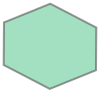

In [16]:
# confirm that geometry column is a geometry object
# this should plot the h3 boundary abitrarily in space
illinois_crash_gdf['geometry'][0]

# can also confirm by checking at column types in gdf
# should be geometry type if uncomment line below
# illinois_crash_gdf.dtypes

## Plot H3 Cells

In [17]:
def create_folium_map(gdf, count_column, caption, map_location=None, zoom_start=8):
  # defaults to being centered over IL
  if map_location is None:
      map_location = [40.0, -89.0]

  # confirm count_column exists
  if count_column not in gdf.columns:
      raise ValueError(f"Column '{count_column}' not found in GeoDataFrame.")

  # calculating min/max for the heat map range
  min_val = gdf[count_column].min() if not gdf[count_column].isnull().all() else 0
  max_val = gdf[count_column].max() if not gdf[count_column].isnull().all() else 1

  # creates Folium map with CartoDB positron base layer
  m = folium.Map(location=map_location, zoom_start=zoom_start, tiles="cartodbpositron")

  # using YlGnBu_09 color scale but lots of options on Folium docs
  colormap = branca.colormap.linear.YlGnBu_09.scale(min_val, max_val)
  colormap.caption = caption

  # styling
  def style_function(feature):
      count = feature["properties"].get(count_column, 0)
      return {
          'fillColor': colormap(count),
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.9
      }

  # add geojson layers
  folium.GeoJson(
      gdf,
      style_function=style_function
  ).add_to(m)

  # add colormap info
  colormap.add_to(m)

  return m

In [18]:
legend_caption = 'Median Vehicles Involved Per Crash'
h3_map = create_folium_map(illinois_crash_gdf, 'median_vehicles', legend_caption)

In [19]:
h3_map